# Model fitting for External Compton 

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
from jetset.jet_model import Jet
from jetset.data_loader import Data,ObsData
from jetset.test_data_helper import  test_SEDs
test_SEDs


['/Users/orion/anaconda3/envs/develop/lib/python3.7/site-packages/jetset-1.1.0-py3.7-macosx-10.7-x86_64.egg/jetset/test_data/SEDs_data/SED_3C345.ecsv',
 '/Users/orion/anaconda3/envs/develop/lib/python3.7/site-packages/jetset-1.1.0-py3.7-macosx-10.7-x86_64.egg/jetset/test_data/SEDs_data/SED_MW_Mrk421.ecsv',
 '/Users/orion/anaconda3/envs/develop/lib/python3.7/site-packages/jetset-1.1.0-py3.7-macosx-10.7-x86_64.egg/jetset/test_data/SEDs_data/SED_MW_Mrk501.ecsv']

In [9]:
data=Data.from_file(test_SEDs[0])


In [10]:
sed_data=ObsData(data_table=data)

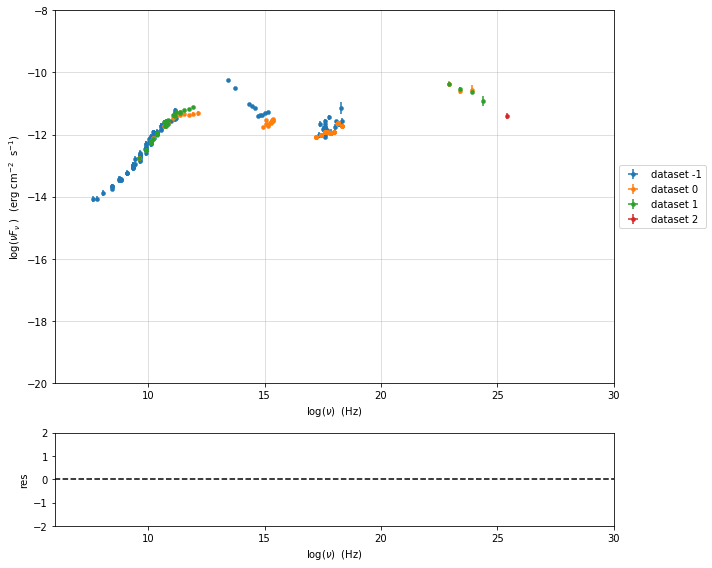

In [11]:
%matplotlib inline
p=sed_data.plot_sed(show_dataset=True)

we filter out the data set `-1` 

current datasets
dataset -1
dataset 0
dataset 1
dataset 2
---> excluding  data_set/s ['-1']
filter -1 192
current datasets
dataset 0
dataset 1
dataset 2
---> data sets left after filtering None
---> data len after filtering=192
current datasets
dataset 0
dataset 1
dataset 2


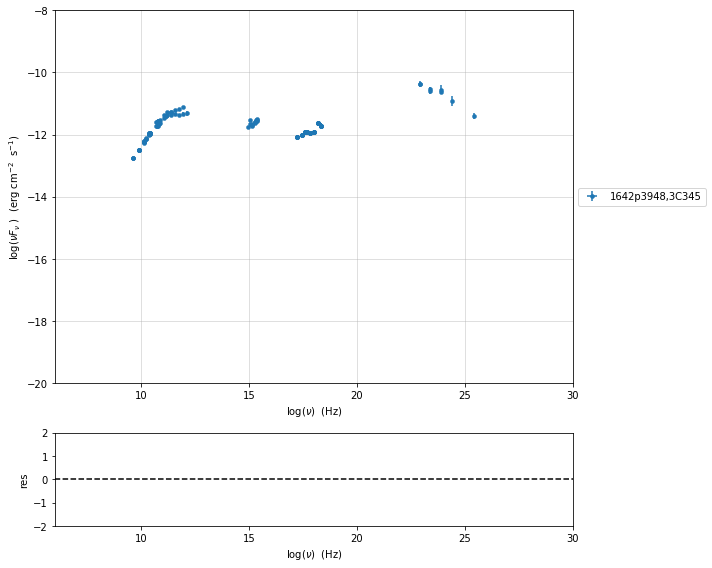

In [12]:
sed_data.show_data_sets()
sed_data.filter_data_set('-1',exclude=True)
sed_data.show_data_sets()
p=sed_data.plot_sed()



***  binning data  ***
---> N bins= 80
---> bin_widht= 0.2



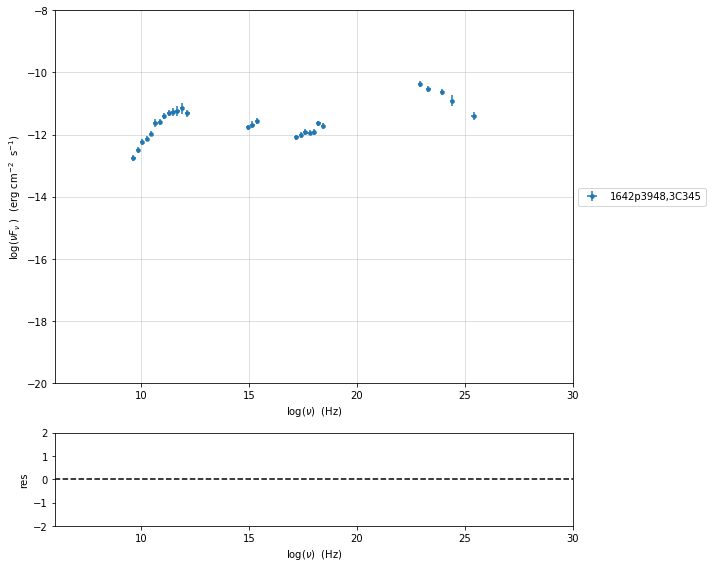

In [13]:
sed_data.group_data(bin_width=.2)
sed_data.add_systematics(0.2,[10.**6,10.**29])
p=sed_data.plot_sed()


*** evaluating spectral indices for data ***
---> initial range for index radio  set to [6.000000,10.000000]
---> range for index radio updated  to [5.900000,10.100000]
---> name = radio            range=[5.900 ,10.100] log(Hz)  photon.val=-7.220146e-01, err=1.374842e-02 

---> initial range for index radio_mm  set to [10.000000,11.000000]
---> range for index radio_mm updated  to [10.000000,11.000000]
---> name = radio_mm         range=[10.000,11.000] log(Hz)  photon.val=-1.145232e+00, err=1.107139e-01 

---> initial range for index mm_IR  set to [11.000000,13.000000]
---> range for index mm_IR updated  to [11.000000,13.000000]
---> name = mm_IR            range=[11.000,13.000] log(Hz)  photon.val=-1.904939e+00, err=7.083441e-02 

---> initial range for index IR_Opt  set to [13.000000,14.000000]
---> not enough data in range for indexIR_Opt 

---> initial range for index Opt_UV  set to [14.000000,16.000000]
---> range for index Opt_UV updated  to [14.000000,16.000000]
---> name = Opt

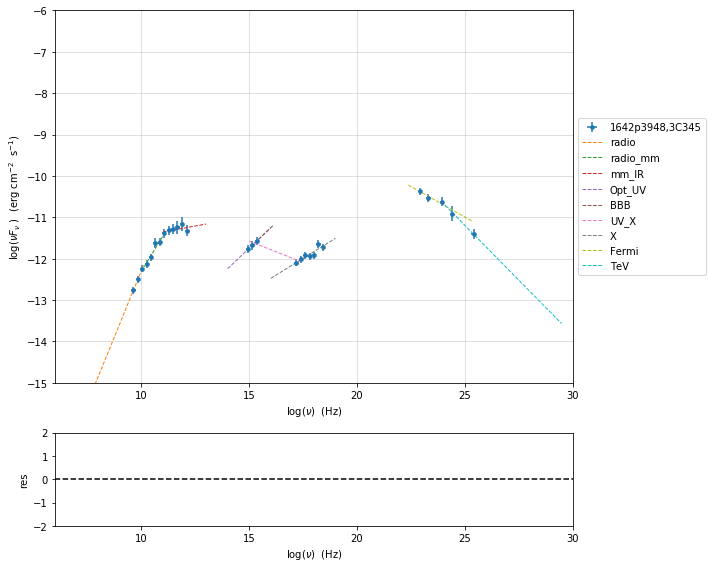

In [14]:
from jetset.sed_shaper import  SEDShape
my_shape=SEDShape(sed_data)
my_shape.eval_indices(silent=True)
p=my_shape.plot_indices()
p.rescale(y_min=-15,y_max=-6)

for the synchrotron sed_shaping we include the check for Big Blue Bump (BBB) component. Moreover, we force the model to use a pure log-parabolic function and not a log-cubic one in order to get a better estimation of the BBB  component. The fit values of the BBB component will be used in the `ObsConstrain` to guess the accretion disk luminosity and temperature

In [17]:
mm,best_fit=my_shape.sync_fit(check_BBB_template=True,
                              check_host_gal_template=False,
                              use_log_par=True,
                              Ep_start=None,
                              minimizer='lsb',
                              silent=True,
                              fit_range=[9,16])


*** Log-Polynomial fitting of the synchrotron component ***
---> first blind fit run,  fit range: [9, 16]
--> class:  LSP

--> class:  LSP
    name      par type      units             val         phys. bound. min phys. bound. max  log  frozen
----------- ----------- ------------- ------------------- ---------------- ---------------- ----- ------
          b   curvature               -0.2984653291941175            -10.0              0.0 False  False
         Ep   peak freq            Hz   11.90849942193066              0.0             30.0  True  False
         Sp   peak flux erg / (cm2 s) -11.233657458385743            -30.0              0.0  True  False
nuFnu_p_BBB nuFnu-scale erg / (cm2 s)  -11.55964975937204            -20.0             20.0 False  False
   nu_scale    nu-scale            Hz 0.07058302184753273             -2.0              2.0 False  False


---> sync       nu_p=+1.190850e+01 (err=+2.238812e-01)  nuFnu_p=-1.123366e+01 (err=+7.306309e-02) curv.=-2.984653e-01 (err=


*** Log-Polynomial fitting of the IC component ***
---> fit range: [16, 26]
---> LogCubic fit


name   par type       units              val          phys. bound. min phys. bound. max  log  frozen
---- ------------ ------------- --------------------- ---------------- ---------------- ----- ------
   b    curvature                -0.11273065291828388            -10.0              0.0 False  False
   c third-degree               -0.010613774612263427            -10.0             10.0 False  False
  Ep    peak freq            Hz    22.731332318664315              0.0             30.0  True  False
  Sp    peak flux erg / (cm2 s)    -10.43073799217408            -30.0              0.0  True  False
---> IC         nu_p=+2.273133e+01 (err=+1.451687e-01)  nuFnu_p=-1.043074e+01 (err=+6.087742e-02) curv.=-1.127307e-01 (err=+1.237407e-02)



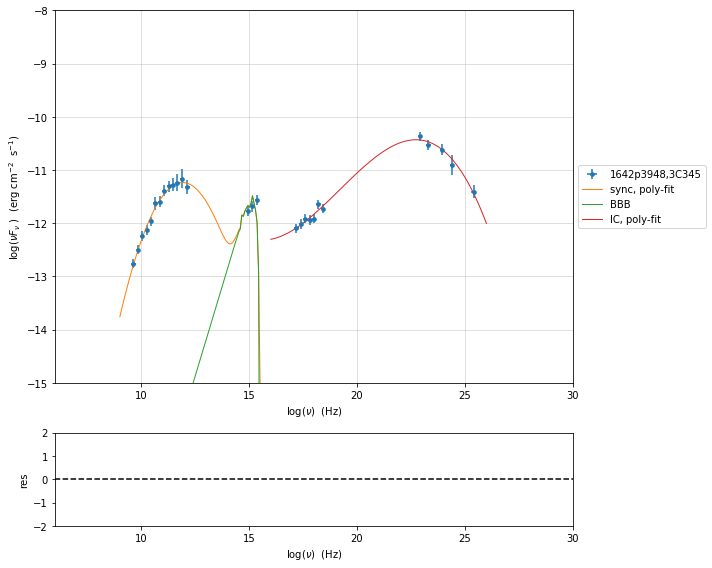

In [18]:
my_shape.IC_fit(fit_range=[16,26],minimizer='minuit', silent=True)
p=my_shape.plot_shape_fit()
p.rescale(y_min=-15)

In this case we use the `constrain_SSC_EC_model`, and we ask to use a dusty torus component external component

In [22]:
from jetset.obs_constrain import ObsConstrain
from jetset.model_manager import  FitModel
from jetset.minimizer import fit_SED
sed_obspar=ObsConstrain(beaming=25,
                        B_range=[0.1,0.2],
                        distr_e='bkn',
                        t_var_sec=7*86400,
                        nu_cut_IR=1E9,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_EC_model(electron_distribution_log_values=False,EC_componets_list=['EC_DT'])



***  constrains parameters from observable ***

---> ***  emitting region parameters  ***
---> name = beam_obj          type = beaming               units = Lorentz-factor*   val = +2.500000e+01  phys-bounds = [+1.000000e-04,No           ] islog = False  froze= False 
---> setting par type redshift, corresponding to par z_cosm
--->  name = z_cosm            type = redshift              units =                   val = +5.930000e-01  phys-bounds = [+0.000000e+00,No           ] islog = False  froze= False 

---> setting par type magnetic_field, corresponding to par B
--->  name = B                 type = magnetic_field        units = G                 val = +1.500000e-01  phys-bounds = [+0.000000e+00,No           ] islog = False  froze= False 

---> setting par type region_size, corresponding to par R
--->  name = R                 type = region_size           units = cm                val = +2.845488e+17  phys-bounds = [+1.000000e+03,+1.000000e+30] islog = False  froze= False 


---> **

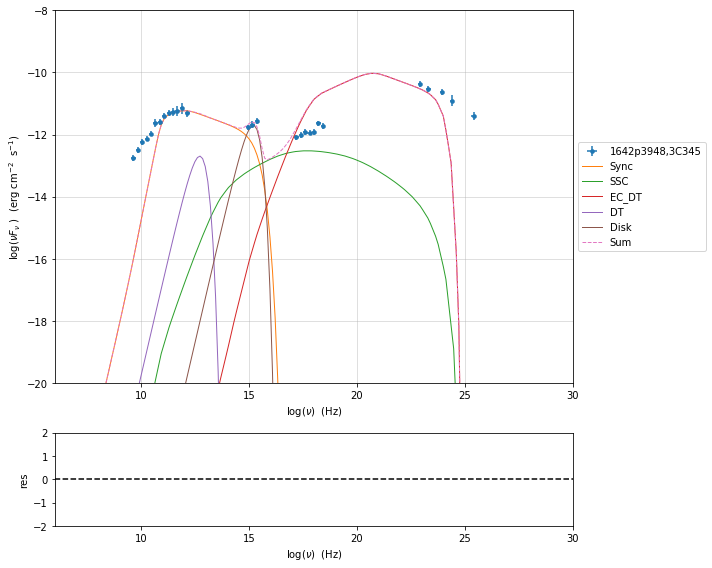

In [23]:
p=prefit_jet.plot_model(sed_data=sed_data)
prefit_jet.save_model('prefit_jet_EC.dat')

The prefit model should works well for the synchrotron component, but the EC one is a bit problematic. We can set as starting values  a slightly hader value of `p`, and a larger value of `gamma_break` and `gmax`. We freeze some parameters, and we also set some `fit_range` values, indeed `minuit` works better if `fit_range` is set for some parameters that might impact significantly on the fit.

In [24]:
jet_minuti=Jet.load_model('prefit_jet_EC.dat')
jet_minuti.set_gamma_grid_size(100)
fit_model_minuit=FitModel( jet=jet_minuti, name='EC-best-fit-lsb')
fit_model_minuit.freeze('z_cosm')
fit_model_minuit.freeze('R_H')
fit_model_minuit.freeze('L_Disk')

fit_model_minuit.freeze('accr_eff')
fit_model_minuit.freeze('R_inner_Sw')
fit_model_minuit.freeze('R_ext_Sw')
fit_model_minuit.parameters.R.fit_range=[1E16,5E18]
fit_model_minuit.parameters.gamma_break.val=600
fit_model_minuit.parameters.p.val=1.8
fit_model_minuit.parameters.gamma_break.fit_range=[100,3000]
fit_model_minuit.parameters.gmin.fit_range=[2,10]

fit_model_minuit.parameters.gmax.val=1E5
fit_model_minuit.parameters.gmax.fit_range=[1000,1E6]


model_minimizer_minuit,best_fit__minuit=fit_SED(fit_model_minuit,sed_data,10.0**11,10**29.0,fitname='SSC-best-fit-minuit',minimizer='minuit')

    name          par type           units               val           phys. bound. min  phys. bound. max   log  frozen
----------- ------------------- --------------- ---------------------- ---------------- ------------------ ----- ------
       T_DT                  DT               K                  100.0                0               None False  False
       R_DT                  DT              cm                  5e+18                0               None False  False
     tau_DT                  DT                                    0.1                0                1.0 False  False
     L_Disk                Disk         erg / s 4.2326884651040774e+45                0               None False  False
 R_inner_Sw                Disk      Sw. radii*                    3.0                0               None False  False
   R_ext_Sw                Disk      Sw. radii*                  500.0                0               None False  False
     T_Disk                Disk         

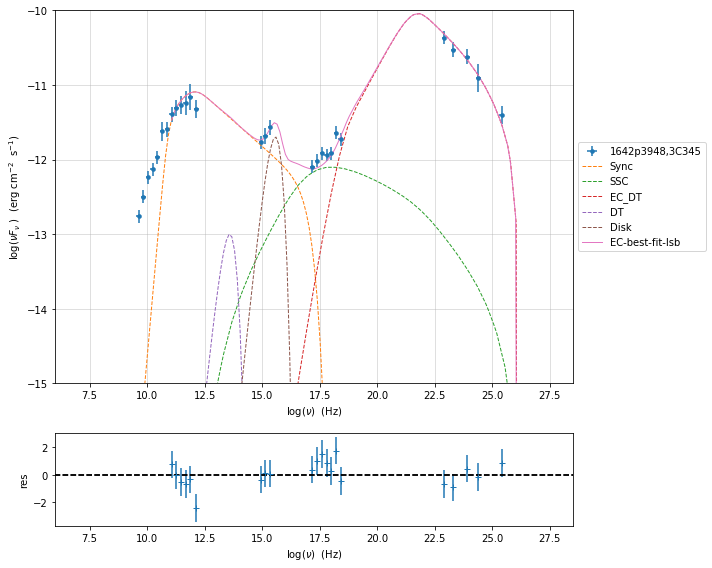

In [25]:
%matplotlib inline
fit_model_minuit.set_nu_grid(1E6,1E30,200)
fit_model_minuit.eval()
p2=fit_model_minuit.plot_model(sed_data=sed_data)
p2.rescale(y_min=-15,y_max=-10,x_min=6,x_max=28.5)

In [26]:
jet_minuti.energetic_report()

-----------------------------------------------------------------------------------------
jet eneregetic report:
     name                  type               units            val          
------------- ----------------------------- --------- ----------------------
          U_e Energy dens. blob rest. frame erg / cm3   0.005731624840412476
          U_p Energy dens. blob rest. frame erg / cm3    0.02048012442336465
          U_B Energy dens. blob rest. frame erg / cm3 0.00038200263399851747
      U_Synch Energy dens. blob rest. frame erg / cm3   8.51281216391543e-05
  U_Synch_DRF Energy dens. disk rest. frame erg / cm3     30.190177406896357
       U_Disk Energy dens. blob rest. frame erg / cm3     1.2898132130819888
        U_BLR Energy dens. blob rest. frame erg / cm3                    0.0
         U_DT Energy dens. blob rest. frame erg / cm3   0.004476146294050553
        U_CMB Energy dens. blob rest. frame erg / cm3                    0.0
   U_Disk_DRF Energy dens. disk rest. fr